In [1]:
import torch
from datasets import load_mnist, get_observation_pixels
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

BATCH_SIZE = 100
train_loader, test_loader, val_loader = load_mnist(BATCH_SIZE)

In [2]:
import pytorch_lightning as pl

from models import LabelMDVAE

class LabelMDVAETrainer(pl.LightningModule):
    def __init__(self, hidden_dims = [128, 256], latent_dim = 2):
        super(LabelMDVAETrainer, self).__init__()
        
        self.model = LabelMDVAE(hidden_dims, latent_dim)
        
    def forward(self, x, x_cond, y):
        return self.model(x,y)
    
    def step(self, batch, batch_idx, mode = 'train'):
        x, x_cond, y = batch
        x_hat, mu, log_var, z = self(x, x_cond, y)
        loss = self.model.loss(x, x_hat, mu, log_var)
        self.log_dict({f"{mode}_{key}": val.item() for key, val in loss.items()}, sync_dist=True)
        return loss['loss']
    
    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'train')
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'val')
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, 'test')
    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=1e-3)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='label-mdvae-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

model = LabelMDVAETrainer()
trainer = pl.Trainer(accelerator='gpu', devices=[5], max_epochs=50, enable_progress_bar=True, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, val_loader)
#save
trainer.save_checkpoint('checkpoints/label_mdvae_50.ckpt')

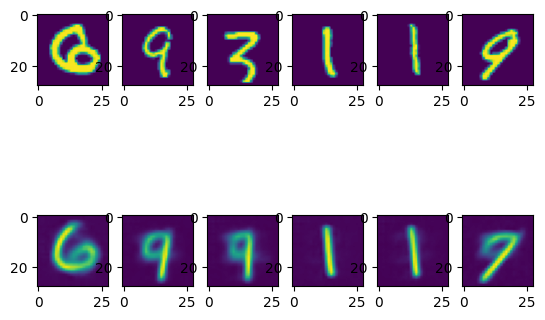

In [3]:
model = LabelMDVAETrainer.load_from_checkpoint('checkpoints/label_mdvae_50.ckpt')
model.eval().cuda(device = 5)

from plotting import plot_samples_with_reconstruction
# plot some samples and their reconstruction

plot_samples_with_reconstruction(model, next(iter(test_loader)))